<a href="https://colab.research.google.com/github/vachagancode/bhiclassification/blob/main/Breast_Histopathology_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Only run this if you haven't downloaded the dataset
!kaggle datasets download paultimothymooney/breast-histopathology-images

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images
License(s): CC0-1.0
100% 3.09G/3.10G [00:33<00:00, 81.9MB/s]
100% 3.10G/3.10G [00:33<00:00, 98.3MB/s]


In [2]:
import zipfile

with zipfile.ZipFile("breast-histopathology-images.zip") as zp:
  zp.extractall("data/")

In [3]:
# Do all teh imports
import torch
from torch import nn
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Torch version: {torch.__version__}\nTorchvision version: {torchvision.__version__}\nDevice: {device}")

Torch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
Device: cuda


In [4]:
import os
import pathlib
source_dir = pathlib.Path("data/IDC_regular_ps50_idx5")
dirs = os.listdir(source_dir)
t_set = int(len(os.listdir("data/IDC_regular_ps50_idx5")) * 0.8)

# train_set = dirs[:t_set]
# test_set = dirs[t_set:]
# train_set,  test_set

In [5]:
import requests

# get teh data_setup.py
with open("data_setup.py", "wb") as f:
  response = requests.get("https://raw.githubusercontent.com/vachagancode/ZarzandOrByuzand_Dectector/refs/heads/main/data_setup.py")
  f.write(response.content)

with open("engine.py", "wb") as f:
  response = requests.get("https://raw.githubusercontent.com/vachagancode/ZarzandOrByuzand_Dectector/refs/heads/main/engine.py")
  f.write(response.content)

In [6]:
!rmdir dataset/.ipynb_checkpoints/
!rmdir .ipynb_checkpoints/

rmdir: failed to remove 'dataset/.ipynb_checkpoints/': No such file or directory
rmdir: failed to remove '.ipynb_checkpoints/': No such file or directory


In [7]:
!mkdir dataset/
!mkdir dataset/train/
!mkdir dataset/test/

In [8]:
# now get all the 0 and 1 (pnegative and positive) cases in one list
import shutil
positive_cases = []
negative_cases = []

os.mkdir("dataset/train/1")
os.mkdir("dataset/train/0")
os.mkdir("dataset/test/1")
os.mkdir("dataset/test/0")
i = 0
for dir in dirs:
  i += 1
  dest = "train" if i <= t_set else "test"
  for c0 in os.listdir(source_dir / f"{dir}/0"):
    negative_cases.append(c0)
    shutil.move(source_dir / f"{dir}/0/{c0}", f"dataset/{dest}/0")
  for c1 in os.listdir(source_dir / f"{dir}/1"):
    positive_cases.append(c1)
    shutil.move(source_dir / f"{dir}/1/{c1}", f"dataset/{dest}/1")

In [9]:
print(f"Total positive cases: {len(positive_cases)}\nTotal negative cases: {len(negative_cases)}")
total_cases = len(positive_cases) + len(negative_cases)
print(f"Total cases: {total_cases}")

Total positive cases: 78786
Total negative cases: 198738
Total cases: 277524


In [10]:
from torchvision import datasets, transforms
from pathlib import Path
from data_setup import create_dataloaders

image_dir = Path("dataset/")
train_dir = image_dir / "train"
test_dir = image_dir / "test"

train_dir, test_dir

(PosixPath('dataset/train'), PosixPath('dataset/test'))

In [11]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

data_transform = transforms.Compose([
    transforms.Resize((50, 50)),
		transforms.ToTensor()
])

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    transform=data_transform
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f89b9c4c0a0>,
 ['0', '1'])

In [12]:
# It's left to build the model

P = 10
H = 50
W = 50

number_of_patches = int((H * W) / P ** 2)

In [13]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels : int = 3, embedding_dim : int = 300, patch_size : int = 10):
    super().__init__()
    self.patcher = nn.Conv2d(
        in_channels=in_channels,
        out_channels=embedding_dim,
        kernel_size=patch_size,
        stride=patch_size,
        padding=0
    )

    self.flatter = nn.Flatten(
        start_dim=2,
        end_dim=3
    )

  def forward(self, x):
    x_patched = self.patcher(x)
    x_flattened = self.flatter(x_patched)

    return x_flattened.permute(0, 2, 1)


In [14]:
# torch.manual_seed(34)

# patchify = PatchEmbedding(in_channels=3, embedding_dim=300, patch_size=10)
# print(image.shape)
# patched_image = patchify(image.unsqueeze(dim=0))
# print(patched_image.shape)

In [15]:
class MSABlock(nn.Module):
  """Creates a multi-head self-attention block ("MSA block" for short)."""
  def __init__(self, embedding_dim : int = 300, num_heads : int = 10, attn_dropout : float = 0):
    super().__init__()

    self.layer_norm = nn.LayerNorm(
        normalized_shape=embedding_dim
    )

    self.multihead_attn = nn.MultiheadAttention(
        embed_dim=embedding_dim,
        num_heads=num_heads,
        dropout=attn_dropout,
        batch_first=True
    )


  def forward(self, x):
    x = self.layer_norm(x)

    attn_output, _ = self.multihead_attn(
        query=x,
        key=x,
        value=x,
        need_weights=False
    )

    return attn_output

In [16]:
class MLPBlock(nn.Module):
  def __init__(self, embedding_dim : int = 300, mlp_size : int = 3072, dropout : float = 0):
    super().__init__()

    self.norm_layer = nn.LayerNorm(
        normalized_shape = embedding_dim
    )

    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim, out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size, out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    x = self.norm_layer(x)

    x = self.mlp(x)

    return x

In [17]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, embedding_dim : int = 300, num_heads : int = 10, attn_dropout : float = 0,
               mlp_size : int = 1072, dropout : float = 0):

    super().__init__()
    self.msa = MSABlock(
        embedding_dim=embedding_dim,
        num_heads=num_heads,
        attn_dropout=0
    )

    self.mlp = MLPBlock(
      embedding_dim=embedding_dim,
      mlp_size=mlp_size,
      dropout=attn_dropout
    )

  def forward(self, x):

    # <... + x>  adding residual connections
    x = self.msa(x) + x
    x = self.mlp(x) + x

    return x

In [18]:
class ViT(nn.Module):
  def __init__(self, image_size : int = 50,
                    in_channels : int = 3,
                    patch_size : int = 10,
                    num_transformer_layers : int = 8,
                    embedding_dim : int = 300,
                    num_heads : int = 10,
                    attn_dropout : float = 0,
                    mlp_size : int = 1072,
                    dropout : float = 0,
                    embedding_dropout : float = 0.1,
                    num_classes : int = 2
               ):
    super().__init__()
    assert image_size % patch_size == 0, "Image size must be divisible with the patch size"

    self.num_patches = (image_size * image_size) // patch_size**2

    self.class_embedding = nn.Parameter(
        data=torch.randn(1, 1, embedding_dim),
        requires_grad=True
    )

    self.position_embedding = nn.Parameter(
        data=torch.randn(1, self.num_patches + 1, embedding_dim),
        requires_grad=True
    )

    self.embedding_dropout = nn.Dropout(
        p=embedding_dropout
    )

    self.patch_embedding = PatchEmbedding(
        in_channels=in_channels,
        patch_size=patch_size,
        embedding_dim=embedding_dim
    )

    self.transformer_encoder = nn.Sequential(
        *[TransformerEncoderLayer(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            mlp_size=mlp_size,
            dropout=dropout
        ) for _ in range(num_transformer_layers)]
    )

    self.classifier = nn.Sequential(
        nn.LayerNorm(
            normalized_shape=embedding_dim
        ),
        nn.Linear(in_features=embedding_dim, out_features=num_classes)
    )

  def forward(self, x):

    batch_size = x.shape[0]

    class_token = self.class_embedding.expand(batch_size, -1, -1)

    x = self.patch_embedding(x)

    x = torch.cat((class_token, x), dim=1)

    x = self.position_embedding + x

    x = self.embedding_dropout(x)

    x = self.transformer_encoder(x)

    x = self.classifier(x[:, 0])

    return x

In [19]:
vit = ViT(num_classes=len(class_names)).to(device)

In [20]:
random_image = torch.randn(1, 3, 50, 50).to(device)

vit(random_image)

tensor([[-0.1578, -0.7049]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [21]:
from engine import train

optimizer = torch.optim.Adam(
  params=vit.parameters(),
	lr=3e-3,
	betas=(0.9, 0.999),
	weight_decay=0.3
)
loss_fn = nn.CrossEntropyLoss()

torch.manual_seed(42)

results = train(
  model=vit,
	train_dataloader=train_dataloader,
	test_dataloader=test_dataloader,
	optimizer=optimizer,
	loss_fn=loss_fn,
	epochs=10,
	device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6011 | train_acc: 0.7165 | test_loss: 0.6030 | test_acc: 0.7140 | 
Epoch: 2 | train_loss: 0.5994 | train_acc: 0.7166 | test_loss: 0.5991 | test_acc: 0.7140 | 
Epoch: 3 | train_loss: 0.5993 | train_acc: 0.7166 | test_loss: 0.5985 | test_acc: 0.7140 | 
Epoch: 4 | train_loss: 0.5996 | train_acc: 0.7166 | test_loss: 0.6090 | test_acc: 0.7140 | 
Epoch: 5 | train_loss: 0.5994 | train_acc: 0.7166 | test_loss: 0.6009 | test_acc: 0.7140 | 
Epoch: 6 | train_loss: 0.5992 | train_acc: 0.7166 | test_loss: 0.6108 | test_acc: 0.7140 | 
Epoch: 7 | train_loss: 0.5996 | train_acc: 0.7166 | test_loss: 0.6035 | test_acc: 0.7140 | 
Epoch: 8 | train_loss: 0.5996 | train_acc: 0.7166 | test_loss: 0.6010 | test_acc: 0.7140 | 
Epoch: 9 | train_loss: 0.5994 | train_acc: 0.7166 | test_loss: 0.6018 | test_acc: 0.7140 | 
Epoch: 10 | train_loss: 0.5992 | train_acc: 0.7166 | test_loss: 0.6014 | test_acc: 0.7140 | 


In [22]:
import requests

with open("utils.py", "wb") as f:
  response = requests.get("https://raw.githubusercontent.com/vachagancode/ZarzandOrByuzand_Dectector/refs/heads/main/utils.py")
  f.write(response.content)

with open("helper_functions.py", "wb") as f:
  response = requests.get("https://raw.githubusercontent.com/vachagancode/ZarzandOrByuzand_Dectector/refs/heads/main/helper_functions.py")
  f.write(response.content)

In [23]:
!mkdir models/

In [24]:
# Save the model

from utils import save_model

model_name = "vit_0.pth"

save_model(
    model=vit,
    target_dir="models/",
    model_name=model_name
)

[INFO] Saving model to: models/vit_0.pth


In [25]:
# Now test the model

# 1. Get a random image

model_0 = ViT(num_classes=len(class_names))
model_0.load_state_dict(torch.load(f"models/{model_name}", weights_only=True))

plot_transform = transforms.Compose([
    transforms.Resize((50, 50))
])

# pred_and_plot_image(
#     model=model,
#     image_path=""
#     class_names=class_names,
#     transform=plot_transform,
#     device=device
# )

In [26]:
import random

pr_image_name = os.listdir("dataset/test/1")[random.randint(0, len(os.listdir("dataset/test/1")))]
nr_image_name = os.listdir("dataset/test/0")[random.randint(0, len(os.listdir("dataset/test/0")))]

pr_path = f"dataset/test/1/{pr_image_name}"
nr_path = f"dataset/test/0/{nr_image_name}"

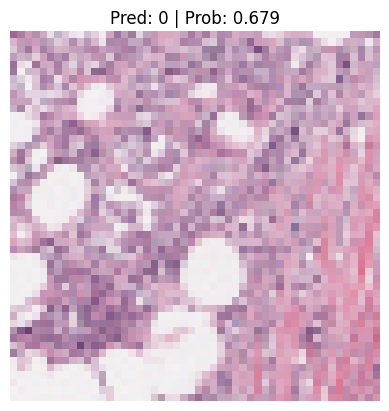

In [27]:
from helper_functions import pred_and_plot_image

pred_and_plot_image(
      model=model_0,
      image_path=pr_path,
      class_names=class_names,
      transform=plot_transform
)
# pred_and_plot_image(
#       model=model_0,
#       image_path=nr_path,
#       class_names=class_names,
#       transform=plot_transform
# )

In [32]:
!git add .
!git commit -m "[COMMIT]: First commit"

Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@2af5b9104e6b.(none)')


In [34]:
!git push -u origin main

error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/vachagancode/Breast_Histopathology_Image_Classification.git'


In [35]:
!git init

Reinitialized existing Git repository in /content/.git/


In [36]:
!git add README.md

fatal: pathspec 'README.md' did not match any files


In [37]:
!git commit -m "first commit"

Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@2af5b9104e6b.(none)')


In [38]:
!git branch -M main

In [39]:
!git remote add origin https://github.com/vachagancode/Breast_Histopathology_Image_Classification.git

error: remote origin already exists.


In [40]:
!git push -u origin main

error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/vachagancode/Breast_Histopathology_Image_Classification.git'
